<a href="https://colab.research.google.com/github/Marko-Vu/Kagle-Projekat/blob/main/kagle_projekat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projekat koji je upitanju dat je na linku [link text](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)

Skidamo data set sa datog linka nakon čega ga je neophodno okačiti na google drive. Zatim povezujemo google collab sa drive-om i ucitavamo nase podatke. Sadrzimo dva skupa train.csv i test.csv od kojih svaki ima po 1460 podataka.

Cilj je predvideti cenu nekretnine na osnovu raznih parametara koji su dati. Opis parametra dat je u textu data_description.


Izbacujemo kolonu 'Id' iz trening i test skupova jer ona nema nikakvu ulogu u predvidjanjima.

U našem trening skupu (training_set) se nalaze i nezavisne varijable i varijabla koju zelimo da predvidimo zbog toga ćemo ga razdvojiti na x_train (nezavisne) i y_train zavisna (SalePrice).

In [240]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest, norm, probplot
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
import statsmodels.api as sm
import statsmodels.tools.tools as smt
import statsmodels.formula.api as smf
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,Lars
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV

drive.mount('/content/drive')
training_set = pd.read_csv('/content/drive/MyDrive/train.csv')
pd.set_option('display.max_columns',None)
x_test=pd.read_csv('/content/drive/MyDrive/test.csv')
training_set=training_set.drop(columns='Id',axis=1)
x_test=x_test.drop(columns='Id',axis=1)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Pre nego što bilo šta krenemo želimo da utvrdimo da li je naš skup podataka potpun tj da li sadrži ili ne sadrži null vrednosti. Ovo je neophodno ukoliko želimo da uopšte probamo oceniti parametre regresionog modela.

In [198]:
training_set.isnull().sum().sum()

np.int64(7829)

In [199]:
x_test.isnull().sum().sum()

np.int64(7878)

Kao što se može primetiti i u jednom i u drugom skupu imamo preko 7800 null vrednosti! Šta sad? najpre hajde da utvrdimo koji parametri imaju najvise null vrednosti da možemo lakše da pratimo da li smo ih očistili ili ne.

In [200]:
print(training_set.isnull().sum().sort_values(ascending=False).head(10))
print(x_test.isnull().sum().sort_values(ascending=False).head(10))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageType        81
GarageFinish      81
dtype: int64
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageFinish      78
GarageYrBlt       78
dtype: int64


Sada se dešava ključni korak naime imamo 1460 podataka. U odredjenim kolonama imamo jakoo veliki broj null vrednosti negde skoro sve (PoolQC):1453. Rešenju problema pristupamo na sledeći način ukoliko su preko polovine podataka trening skupa, dakle preko 730 vrednosti null tada tu kolonu nećemo posmatrati i izbacićemo je iz razmatranja, kada to uradimo moramo i odgovarajuću kolonu iz test skupa izbaciti. Ukoliko je manje od 730 onda ćemo null vrednosti dopuniti sa srednjom vrednosti svih koje imamo u toj koloni ukoliko je numericka vrednost odnosno najčešćom vrednošću modom ukoliko je kategorijalna. Zatim isto ponavljamo za vrednosti test skupa.

In [201]:
threshold=len(training_set)//2

for col in training_set.columns:
    if training_set[col].isnull().sum() >= threshold:
        training_set.drop(columns=col, inplace=True)
        x_test.drop(columns=col, inplace=True)  # keep sets aligned
    elif training_set[col].isnull().sum() > 0:
        # Fill numeric with mean
        if training_set[col].dtype in ['float64', 'int64']:
            mean_val = training_set[col].mean()
            training_set[col].fillna(mean_val, inplace=True)
            x_test[col].fillna(mean_val, inplace=True)
        else:
            # For categorical columns, fill with mode
            mode_val = training_set[col].mode()[0]
            training_set[col].fillna(mode_val, inplace=True)
            x_test[col].fillna(mode_val, inplace=True)

for col in x_test.columns:
  if x_test[col].isnull().sum()>=threshold:
    x_test.drop(columns=col,inplace=True)
    training_set.drop(columns=col,inplace=True)
  elif x_test[col].isnull().sum()>0:
    if x_test[col].dtype in ['float64','int64']:
      mean_val=x_test[col].mean()
      x_test[col].fillna(mean_val,inplace=True)
      training_set[col].fillna(mean_val,inplace=True)
    else:
      mode_val=x_test[col].mode()[0]
      x_test[col].fillna(mode_val,inplace=True)
      training_set[col].fillna(mode_val,inplace=True)


/tmp/ipython-input-201-992141919.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_set[col].fillna(mean_val, inplace=True)
/tmp/ipython-input-201-992141919.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

In [202]:
y_train=training_set['SalePrice']
x_train=training_set.drop(columns='SalePrice')


In [203]:
print(x_train.isnull().sum().sort_values(ascending=False).head(10))
print(x_test.isnull().sum().sort_values(ascending=False).head(10))

MSSubClass     0
MSZoning       0
LotFrontage    0
LotArea        0
Street         0
LotShape       0
LandContour    0
Utilities      0
LotConfig      0
LandSlope      0
dtype: int64
MSSubClass     0
MSZoning       0
LotFrontage    0
LotArea        0
Street         0
LotShape       0
LandContour    0
Utilities      0
LotConfig      0
LandSlope      0
dtype: int64


In [204]:
training_set

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Gd,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,Gd,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,0,4,2010,WD,Normal,142125


In [205]:
x_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Gd,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,0,8,2007,WD,Normal
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,0,2,2010,WD,Normal
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,2500,5,2010,WD,Normal
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,Gd,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,0,4,2010,WD,Normal


In [206]:
x_test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,Gd,Attchd,1961.000000,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,Gd,Attchd,1958.000000,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000000,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000000,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,Gd,Attchd,1992.000000,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,Gd,Attchd,1978.506164,Unf,0.0,0.0,TA,TA,Y,0,0,0,0,0,0,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,Gd,CarPort,1970.000000,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.000000,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,Gd,Attchd,1978.506164,Unf,0.0,0.0,TA,TA,Y,80,32,0,0,0,0,700,7,2006,WD,Normal


Da ne bi posao radili duplo spojicemo x_train i y_train u isti data_frame pa cemo ih posle opet vratiti u odnosu 50% ,50%

In [207]:
x = pd.concat([x_train, x_test], axis=0)

x

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,Gd,Attchd,2003.000000,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,Gd,Attchd,1978.506164,Unf,0.0,0.0,TA,TA,Y,0,0,0,0,0,0,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,Gd,CarPort,1970.000000,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.000000,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,Gd,Attchd,1978.506164,Unf,0.0,0.0,TA,TA,Y,80,32,0,0,0,0,700,7,2006,WD,Normal


Kao što se može primetiti ostaje nam da se rešimo ovih kategorijalnih promenljivih i da ih na neki način kodiramo u numericke vrednosti. Ovo moramo odraditi pametno, naime imamo da tako kazem nekoliko kategorija:



1.   Numeričke vrednosti prve vrste - ovde postoje dve vrste numerickih vrednosti one koje nose informaciju svojstvenu numeričkoj moći recimo LotArea nam kaže površinu u kvadratnim stopama i takve ne želimo da menjamo
2.   Numeričke vrednosti druge vrste - u ovu kategoriju spadaju one kolone koje kategorijalnu osobinu opisuju numericki, prvo sta treba da se pitamo je da li trebamo da koristimo one code at time ili da ostavimo u rangu od 0 do (broj razlicitih kategorija)-1. Pitamo se da li kategorije doprinose promeni cene značajno ili ne.
3.   Binarne vrednosti dakle imamo samo dve opcije to su samo Street i CentralAir
4.   Kategorijalne vrednosti koje ne nose podatke bitne za predikciju njih zelimo one code at time jer zelimo da svaka od kategorija isto doprinosi predikciji


5.   Kategorijalne vrednosti koje nose bitne podatke za predikciju, kod njih zelimo neki hierarhijski odnos, on mora i prirodno postojati







Hajde najpre da kodiramo neordinalne kategorijalne kolone kodiramo u numericke,tj one koje ne nose znacajnu informaciju za predvidjanje i nemaju jasan poredak zatim ćemo ih one encodovati.

In [208]:
categorical_cols = [
    'MSZoning', 'LotShape', 'LandContour',
     'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
    'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd','Foundation'
    ,'Heating','Electrical','GarageType'
    ,'SaleType'
    ,'SaleCondition'
]

for category in categorical_cols:
  x[category]=x[category].astype('category').cat.codes

In [209]:
x

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,Pave,3,3,AllPub,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,196.0,Gd,TA,2,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,1,Ex,Y,4,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,Gd,1,2003.000000,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,0,2,2008,8,4
1,20,3,80.0,9600,Pave,3,3,AllPub,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,0.0,TA,TA,1,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,1,Ex,Y,4,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,1,1976.000000,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,0,5,2007,8,4
2,60,3,68.0,11250,Pave,0,3,AllPub,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,162.0,Gd,TA,2,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,1,Ex,Y,4,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,1,2001.000000,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,0,9,2008,8,4
3,70,3,60.0,9550,Pave,0,3,AllPub,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,0.0,TA,TA,0,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,1,Gd,Y,4,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,5,1998.000000,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,0,2,2006,8,0
4,60,3,84.0,14260,Pave,0,3,AllPub,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,350.0,Gd,TA,2,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,1,Ex,Y,4,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,1,2000.000000,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,0,12,2008,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,4,21.0,1936,Pave,3,3,AllPub,4,0,10,2,2,3,5,4,7,1970,1970,1,1,5,5,0.0,TA,TA,1,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,1,Gd,Y,4,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,Gd,1,1978.506164,Unf,0.0,0.0,TA,TA,Y,0,0,0,0,0,0,0,6,2006,8,4
1455,160,4,21.0,1894,Pave,3,3,AllPub,4,0,10,2,2,4,5,4,5,1970,1970,1,1,5,5,0.0,TA,TA,1,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,1,TA,Y,4,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,Gd,4,1970.000000,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,0,4,2006,8,0
1456,20,3,160.0,20000,Pave,3,3,AllPub,4,0,11,2,2,0,2,5,7,1960,1996,1,1,12,13,0.0,TA,TA,1,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,1,Ex,Y,4,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,5,1960.000000,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,0,9,2006,8,0
1457,85,3,62.0,10441,Pave,3,3,AllPub,4,0,11,2,2,0,6,5,5,1992,1992,1,1,6,15,0.0,TA,TA,2,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,1,TA,Y,4,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,Gd,1,1978.506164,Unf,0.0,0.0,TA,TA,Y,80,32,0,0,0,0,700,7,2006,8,4


In [210]:

# Loop through each column
for col in categorical_cols:
    unique_vals = x[col].nunique()

    # If it's not already binary, dummy encode
    if unique_vals > 2:
        dummies = pd.get_dummies(x[col], prefix=col, drop_first=True, dtype=int)
        x = pd.concat([x.drop(columns=col), dummies], axis=1)


x

,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,LotShape_1,LotShape_2,LotShape_3,LandContour_1,LandContour_2,LandContour_3,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_1,LandSlope_2,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,Electrical_1,Electrical_2,Electrical_3,Electrical_4,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,60,65.0,8450,Pave,AllPub,7,5,2003,2003,196.0,Gd,TA,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,Ex,Y,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,Gd,2003.000000,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,0,2,2008,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,Pave,AllPub,6,8,1976,1976,0.0,TA,TA,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,Ex,Y,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,1976.000000,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,0,5,2007,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,Pave,AllPub,7,5,2001,2002,162.0,Gd,TA,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,Ex,Y,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,2001.000000,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,0,9,2008,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,Pave,AllPub,7,5,1915,1970,0.0,TA,TA,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,Gd,Y,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Ty

Kodiranje Binarnih kategorija (CentralAir,Street) CentralAir: N:0 ; Y:1:
Street Grvl:0 ; Pave:1

In [211]:
x['CentralAir'] = x['CentralAir'].map({'N': 0, 'Y': 1})

x['Street'] = x['Street'].map({'Grvl': 0, 'Pave': 1})

x

,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,LotShape_1,LotShape_2,LotShape_3,LandContour_1,LandContour_2,LandContour_3,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_1,LandSlope_2,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,Electrical_1,Electrical_2,Electrical_3,Electrical_4,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,60,65.0,8450,1,AllPub,7,5,2003,2003,196.0,Gd,TA,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,Ex,1,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,Gd,2003.000000,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,0,2,2008,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,20,80.0,9600,1,AllPub,6,8,1976,1976,0.0,TA,TA,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,Ex,1,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,1976.000000,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,0,5,2007,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,60,68.0,11250,1,AllPub,7,5,2001,2002,162.0,Gd,TA,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,Ex,1,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,2001.000000,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,0,9,2008,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,70,60.0,9550,1,AllPub,7,5,1915,1970,0.0,TA,TA,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,Gd,1,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,1998.

Sada želimo da kodiramo Ordinalne kategorije u odredjenom redosledu najmanji broj ce označivati nagoru/najslabiju vrednost,osobinu u kategoriji, a najveći najbolju.

In [212]:
ms_subclass_map = {
    30: 1,    # 1-STORY 1945 & OLDER
    45: 2,    # 1-1/2 STORY UNFINISHED
    50: 3,    # 1-1/2 STORY FINISHED
    40: 4,    # 1-STORY W/FINISHED ATTIC
    20: 5,    # 1-STORY 1946 & NEWER
    120: 6,   # 1-STORY PUD (NEWER)
    70: 7,    # 2-STORY 1945 & OLDER
    60: 8,    # 2-STORY 1946 & NEWER
    160: 9,   # 2-STORY PUD
    75: 10,   # 2-1/2 STORY
    80: 11,   # SPLIT/MULTI-LEVEL
    85: 12,   # SPLIT FOYER
    150: 13,  # 1.5-STORY PUD
    180: 14,  # MULTI-LEVEL PUD
    90: 15,   # DUPLEX
    190: 16   # 2-FAMILY CONVERSION
}
x['MSSubClass'] = x['MSSubClass'].map(ms_subclass_map)


q_subclass_map ={'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
Naq_subclass_map ={'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}

u_subclass_map={'ELO':1,'NoSeWa':2,'NoSeWa':3,'NoSewr':4,'AllPub':5}

x['Utilities'] = x['Utilities'].map(u_subclass_map)

x['ExterQual'] = x['ExterQual'].map(q_subclass_map)


x['ExterCond'] = x['ExterCond'].map(q_subclass_map)
x


x['BsmtQual'] = x['BsmtQual'].map(Naq_subclass_map)


x['BsmtCond'] = x['BsmtCond'].map(Naq_subclass_map)

be_subclass_map={'Na':0,'No':1,'Mn':2,'Av':3,'Gd':4}

x['BsmtExposure'] = x['BsmtExposure'].map(be_subclass_map)


bt_subclass_map ={'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}

x['BsmtFinType1'] = x['BsmtFinType1'].map(bt_subclass_map)


bt_subclass_map ={'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6}

x['BsmtFinType2'] = x['BsmtFinType2'].map(bt_subclass_map)


x['HeatingQC'] = x['HeatingQC'].map(q_subclass_map)



x['KitchenQual'] = x['KitchenQual'].map(q_subclass_map)

func_subclass_map={'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7}
x['Functional'] = x['Functional'].map(func_subclass_map)



x['FireplaceQu'] = x['FireplaceQu'].map(Naq_subclass_map)

garage_fin_subclass_map={'Na':0,'Unf':1,'RFn':2,'Fin':3}


x['GarageFinish'] = x['GarageFinish'].map(garage_fin_subclass_map)


x['GarageQual'] = x['GarageQual'].map(Naq_subclass_map)

x['GarageCond'] = x['GarageCond'].map(Naq_subclass_map)


PD_subclass_map={'N':0,'P':1,'Y':2}

x['PavedDrive'] = x['PavedDrive'].map(PD_subclass_map)


x

,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,LotShape_1,LotShape_2,LotShape_3,LandContour_1,LandContour_2,LandContour_3,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_1,LandSlope_2,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,Electrical_1,Electrical_2,Electrical_3,Electrical_4,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,8,65.0,8450,1,5,7,5,2003,2003,196.0,4,3,4,3,1,6,706.0,1,0.0,150.0,856.0,5,1,856,854,0,1710,1.0,0.0,2,1,3,1,4,8,7,0,4,2003.000000,2,2.0,548.0,3,3,2,0,61,0,0,0,0,0,2,2008,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,5,80.0,9600,1,5,6,8,1976,1976,0.0,3,3,4,3,4,5,978.0,1,0.0,284.0,1262.0,5,1,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,7,1,3,1976.000000,2,2.0,460.0,3,3,2,298,0,0,0,0,0,0,5,2007,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,8,68.0,11250,1,5,7,5,2001,2002,162.0,4,3,4,3,2,6,486.0,1,0.0,434.0,920.0,5,1,920,866,0,1786,1.0,0.0,2,1,3,1,4,6,7,1,3,2001.000000,2,2.0,608.0,3,3,2,0,42,0,0,0,0,0,9,2008,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,7,60.0,9550,1,5,7,5,1915,1970,0.0,3,3,3,4,1,5,216.0,1,0.0,540.0,756.0,4,1,961,756,0,1717,1.0,0.0,1,0,3,1,4,7,7,1,4,1998.000000,1,3.0,642.0,3,3,2,0,35,272,0,0,0,0,2,2006,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1

Želimo sve da prebacimo u int tip radi lakših analiza

In [213]:

x['GarageYrBlt'] = x['GarageYrBlt'].astype(int)
x['BsmtFinSF1'] = x['BsmtFinSF1'].astype(int)
x['BsmtFinSF2'] = x['BsmtFinSF2'].astype(int)
x['BsmtUnfSF'] = x['BsmtUnfSF'].astype(int)
x['TotalBsmtSF'] = x['TotalBsmtSF'].astype(int)
x['BsmtFullBath'] = x['BsmtFullBath'].astype(int)
x['BsmtHalfBath'] = x['BsmtHalfBath'].astype(int)
x['GarageCars'] = x['GarageCars'].astype(int)
x['GarageArea'] = x['GarageArea'].astype(int)
x['LotFrontage'] = x['LotFrontage'].astype(int)
x['GarageYrBlt'] = x['GarageYrBlt'].astype(int)
x['MasVnrArea'] = x['MasVnrArea'].astype(int)

# Proveri tipove kolona
print(x.dtypes.value_counts())

# Ako želiš videti sve kolone koje nisu celobrojne:
non_int_cols = x.select_dtypes(exclude=['int64', 'int32']).columns
print("Nisu celobrojne:", list(non_int_cols))

x

int64    193
Name: count, dtype: int64
Nisu celobrojne: []


,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,LotShape_1,LotShape_2,LotShape_3,LandContour_1,LandContour_2,LandContour_3,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_1,LandSlope_2,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,Electrical_1,Electrical_2,Electrical_3,Electrical_4,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,8,65,8450,1,5,7,5,2003,2003,196,4,3,4,3,1,6,706,1,0,150,856,5,1,856,854,0,1710,1,0,2,1,3,1,4,8,7,0,4,2003,2,2,548,3,3,2,0,61,0,0,0,0,0,2,2008,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,5,80,9600,1,5,6,8,1976,1976,0,3,3,4,3,4,5,978,1,0,284,1262,5,1,1262,0,0,1262,0,1,2,0,3,1,3,6,7,1,3,1976,2,2,460,3,3,2,298,0,0,0,0,0,0,5,2007,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,8,68,11250,1,5,7,5,2001,2002,162,4,3,4,3,2,6,486,1,0,434,920,5,1,920,866,0,1786,1,0,2,1,3,1,4,6,7,1,3,2001,2,2,608,3,3,2,0,42,0,0,0,0,0,9,2008,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,7,60,9550,1,5,7,5,1915,1970,0,3,3,3,4,1,5,216,1,0,540,756,4,1,961,756,0,1717,1,0,1,0,3,1,4,7,7,1,4,1998,1,3,642,3,3,2,0,35,272,0,0,0,0,2,2006,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0

In [214]:
n_train = 1460  # or len(y_train) if you saved target
x_train = x.iloc[:n_train, :].copy()
x_test = x.iloc[n_train:, :].copy()
x_train

,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,LotShape_1,LotShape_2,LotShape_3,LandContour_1,LandContour_2,LandContour_3,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_1,LandSlope_2,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,Electrical_1,Electrical_2,Electrical_3,Electrical_4,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,8,65,8450,1,5,7,5,2003,2003,196,4,3,4,3,1,6,706,1,0,150,856,5,1,856,854,0,1710,1,0,2,1,3,1,4,8,7,0,4,2003,2,2,548,3,3,2,0,61,0,0,0,0,0,2,2008,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,5,80,9600,1,5,6,8,1976,1976,0,3,3,4,3,4,5,978,1,0,284,1262,5,1,1262,0,0,1262,0,1,2,0,3,1,3,6,7,1,3,1976,2,2,460,3,3,2,298,0,0,0,0,0,0,5,2007,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,8,68,11250,1,5,7,5,2001,2002,162,4,3,4,3,2,6,486,1,0,434,920,5,1,920,866,0,1786,1,0,2,1,3,1,4,6,7,1,3,2001,2,2,608,3,3,2,0,42,0,0,0,0,0,9,2008,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,7,60,9550,1,5,7,5,1915,1970,0,3,3,3,4,1,5,216,1,0,540,756,4,1,961,756,0,1717,1,0,1,0,3,1,4,7,7,1,4,1998,1,3,642,3,3,2,0,35,272,0,0,0,0,2,2006,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0

In [215]:

x_test

,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,LotShape_1,LotShape_2,LotShape_3,LandContour_1,LandContour_2,LandContour_3,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_1,LandSlope_2,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,Electrical_1,Electrical_2,Electrical_3,Electrical_4,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5
0,5,80,11622,1,5,5,6,1961,1961,0,3,3,3,3,1,3,468,2,144,270,882,3,1,896,0,0,896,0,0,1,0,2,1,3,5,7,0,4,1961,1,1,730,3,3,2,140,0,0,0,120,0,0,6,2010,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,5,81,14267,1,5,6,6,1958,1958,108,3,3,3,3,1,5,923,1,0,406,1329,3,1,1329,0,0,1329,0,0,1,1,3,1,4,6,7,0,4,1958,1,1,312,3,3,2,393,36,0,0,0,0,12500,6,2010,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,8,74,13830,1,5,5,5,1997,1998,0,3,3,4,3,1,6,791,1,0,137,928,4,1,928,701,0,1629,0,0,2,1,3,1,3,6,7,1,3,1997,3,2,482,3,3,2,212,34,0,0,0,0,0,3,2010,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,8,78,9978,1,5,6,6,1998,1998,20,3,3,3,3,1,6,602,1,0,324,926,5,1,926,678,0,1604,0,0,2,1,3,1,4,7,7,1,4,1998,3,2,470,3,3,2,360,36,0,0,0,0,0,6,2010,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0

Završili smo sa pripremanjem Data seta sada cemo da se malo pozabavimo sa osobinama podataka naime prvo cemo da nadjemo OLS ocenu, reziduale razlika stvarne i predvidjene vrednosti nakon cega cemo utvrditi da li reziduali prate homoskedasticnost i normalnu raspodelu.

In [216]:
x_train.columns = x_train.columns.str.replace(' ', '_')

train_x_y = pd.concat([x_train, y_train], axis=1)
train_x_y

,MSSubClass,LotFrontage,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,LotShape_1,LotShape_2,LotShape_3,LandContour_1,LandContour_2,LandContour_3,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_1,LandSlope_2,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,Heating_1,Heating_2,Heating_3,Heating_4,Heating_5,Electrical_1,Electrical_2,Electrical_3,Electrical_4,GarageType_1,GarageType_2,GarageType_3,GarageType_4,GarageType_5,SaleType_1,SaleType_2,SaleType_3,SaleType_4,SaleType_5,SaleType_6,SaleType_7,SaleType_8,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SalePrice
0,8,65,8450,1,5,7,5,2003,2003,196,4,3,4,3,1,6,706,1,0,150,856,5,1,856,854,0,1710,1,0,2,1,3,1,4,8,7,0,4,2003,2,2,548,3,3,2,0,61,0,0,0,0,0,2,2008,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,208500
1,5,80,9600,1,5,6,8,1976,1976,0,3,3,4,3,4,5,978,1,0,284,1262,5,1,1262,0,0,1262,0,1,2,0,3,1,3,6,7,1,3,1976,2,2,460,3,3,2,298,0,0,0,0,0,0,5,2007,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,181500
2,8,68,11250,1,5,7,5,2001,2002,162,4,3,4,3,2,6,486,1,0,434,920,5,1,920,866,0,1786,1,0,2,1,3,1,4,6,7,1,3,2001,2,2,608,3,3,2,0,42,0,0,0,0,0,9,2008,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,223500
3,7,60,9550,1,5,7,5,1915,1970,0,3,3,3,4,1,5,216,1,0,540,756,4,1,961,756,0,1717,1,0,1,0,3,1,4,7,7,1,4,1998,1,3,642,3,3,2,0,35,272,0,0,0,0,2,2006,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,

In [217]:




train_kolone = [col for col in train_x_y.columns if col != 'SalePrice']
print(train_kolone)


['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Utilities', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_1', 'MSZoning_2', 'MSZoning_3', 'MSZoning_4', 'LotShape_1', 'LotShape_2', 'LotShape_3', 'LandContour_1', 'LandContour_2', 'LandContour_3', 'LotConfig_1', 'LotConfig_2', 'LotConfig_3', 'LotConfig_4', 'LandSlope_1', 'LandSlope_2', 'Neighborh

Racunamo Ordinary least squares i predvidjamo za dato x_train pa racunamo reziduale

In [218]:
train_kolone_q = [f'Q("{col}")' for col in train_kolone]
mlr = smf.ols(formula='SalePrice ~ ' + '+'.join(train_kolone_q), data=train_x_y).fit()

#Normalna raspodela

y_train_pred=mlr.predict(train_x_y)
residuals=y_train-y_train_pred


Testiramo Normalnos raspodele reziduala

❌ Residuals not normal (reject H0)


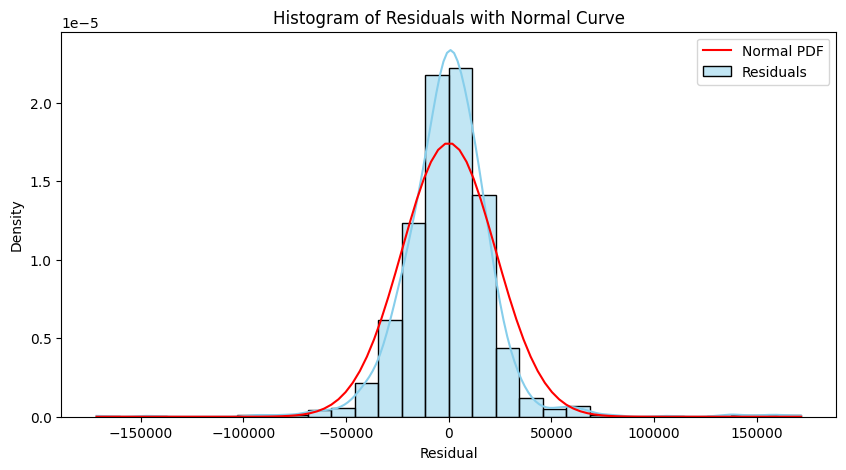

In [231]:
# Perform D’Agostino and Pearson’s test
stat, p = normaltest(residuals)
if p > 0.05:
    print("✅ Residuals likely normal (fail to reject H0)")
else:
    print("❌ Residuals not normal (reject H0)")

# Histogram with KDE
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, stat="density", bins=30, color="skyblue", label="Residuals")

# Overlay standard normal distribution
x = np.linspace(residuals.min(), residuals.max(), 100)
plt.plot(x, norm.pdf(x, np.mean(residuals), np.std(residuals)), color='red', label='Normal PDF')
plt.title("Histogram of Residuals with Normal Curve")
plt.xlabel("Residual")
plt.ylabel("Density")
plt.legend()
plt.show()

Testiramo Homoskedasticnost reziduala potreban nam je x_train uz intercept term tj konstantu

In [220]:
x_train_with_const = sm.add_constant(x_train)
bptest = sms.het_breuschpagan(resid=mlr.resid,exog_het= x_train_with_const)
if bptest[1] > 0.05:
    print('✅ Homoskedasticity present (Breusch-Pagan: linear assumptions)')
else:
    print('❌ Heteroskedasticity present (Breusch-Pagan: linear assumptions)')

# White's Test
wtest = sms.het_white(resid=mlr.resid, exog=x_train_with_const)
if wtest[1] > 0.05:
    print('✅ Homoskedasticity present (White: general functional form)')
else:
    print('❌ Heteroskedasticity present (White: general functional form)')


❌ Heteroskedasticity present (Breusch-Pagan: linear assumptions)
✅ Homoskedasticity present (White: general functional form)


Buduci da je broj kolona dosta velik 193 pouzdaniji nam je BP-test te cemo smatrati sa odredjenim nivoom poverenja da je Heteroskedasticnost prisutna.

Hajde sada da vidimo sta mozemo zakljuciti o povezanosti tj kolinearnosti nasih podataka

In [221]:
# Kombinuj podatke
combined = pd.concat([x_train, y_train], axis=1)

# Izračunaj korelacije sa ciljnim atributom
correlations = combined.corr()['SalePrice'].drop('SalePrice').sort_values(key=abs, ascending=False)

# Prikaz top 10
print(correlations.head(10))


OverallQual    0.790982
GrLivArea      0.708624
ExterQual      0.682639
KitchenQual    0.659600
BsmtQual       0.650138
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
1stFlrSF       0.605852
FullBath       0.560664
Name: SalePrice, dtype: float64


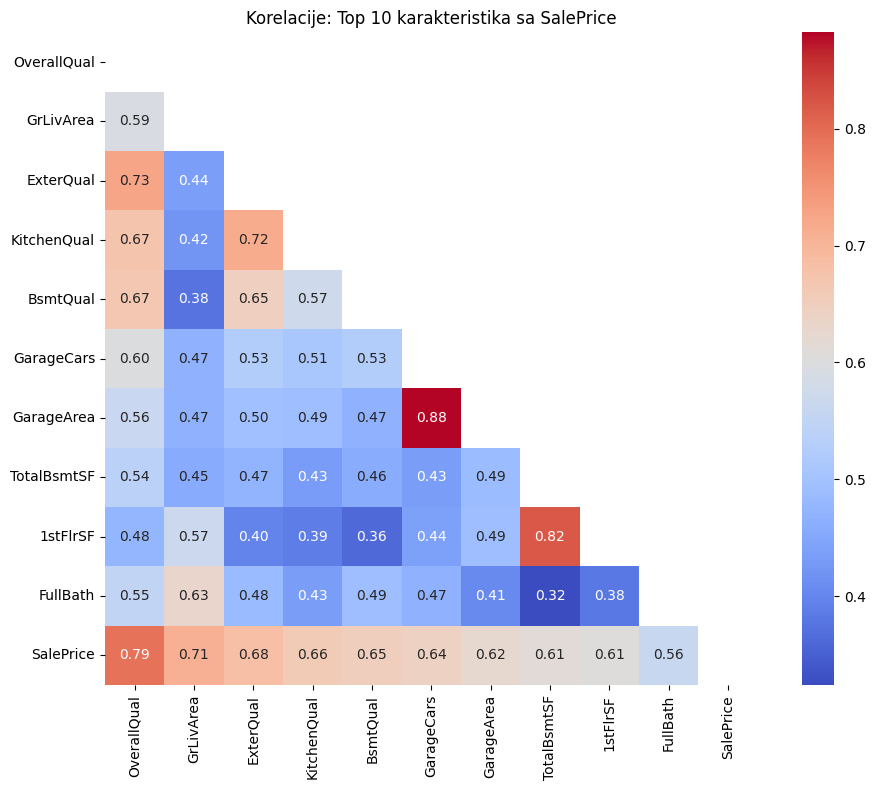

In [222]:
import seaborn as sns
import matplotlib.pyplot as plt

top10_features = correlations.head(10).index.tolist()
top10_corr = combined[top10_features + ['SalePrice']].corr()
mask=np.triu(np.ones_like(top10_corr,dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(top10_corr, mask=mask,annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Korelacije: Top 10 karakteristika sa SalePrice")
plt.tight_layout()
plt.show()


Kao sto se da primetiti redom ove promenljive imaju najvecu kolinearnost sa Sale price, ali neko od njih su takodje dosta korelisane ovo je bitno za vizuelizaciju da bismo razumeli nacin na koji će kasnije metode resiti ovaj problem.

Sada možemo krenuti sa samim mašinskim učenjem i linearnim regresionim modelom predvidjanja najpre ćemo standardizovati x_train,y_train

In [223]:
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Sada smo spremni za linearnu regresiju predvidjamo y_pred pomocu Linearne Regresije, Ridge,Lasso,Elastic Net i LARS modela.

Linearna regresija

In [224]:
lr=LinearRegression()
lr.fit(x_train_scaled,y_train)
y_pred_test_lr=lr.predict(x_test_scaled)


y_pred_test_lr = pd.DataFrame({
    "SalePrice": y_pred_test_lr
})
y_pred_test_lr.to_csv("submission.csv", index=False)
y_pred_test_lr

,SalePrice
0,117190.981934
1,168475.288014
2,176424.377255
3,186734.656874
4,213228.434034
...,...
1454,70666.680783
1455,69973.506119
1456,168641.433216
1457,99701.506354


Ridge Regresija

In [225]:
ridge_model=Ridge(alpha=1.0)
ridge_model.fit(x_train_scaled,y_train)

y_pred_test_ridge=ridge_model.predict(x_test_scaled)

y_pred_test_ridge = pd.DataFrame({
    "SalePrice": y_pred_test_ridge
})
y_pred_test_ridge

,SalePrice
0,115865.144630
1,168070.966036
2,175789.875623
3,186256.241110
4,213653.989502
...,...
1454,70309.159296
1455,69472.924479
1456,167199.600343
1457,99515.177602


Lasso Regresija

In [226]:
lasso_model=Lasso(alpha=1,max_iter=5000)
lasso_model.fit(x_train_scaled,y_train,)
y_pred_test_lasso=lasso_model.predict(x_test_scaled)

y_pred_test_lasso=pd.DataFrame({'SalePrice':y_pred_test_lasso})

selected_features = np.array(x_train.columns)[lasso_model.coef_ == 0]
print("Unselected features:", selected_features)

y_pred_test_lasso

Unselected features: ['Exterior1st_4' 'Heating_3']


,SalePrice
0,116981.588100
1,168470.032333
2,176420.115993
3,186716.796948
4,213231.034207
...,...
1454,70642.882173
1455,69731.903435
1456,168545.197580
1457,99743.591284


Elastic Net regresija

In [227]:
EN_model=ElasticNet(max_iter=5000)
EN_model.fit(x_train_scaled,y_train)

y_pred_test_EN=EN_model.predict(x_test_scaled)

y_pred_test_EN=pd.DataFrame({'SalePrice':y_pred_test_EN})

selected_features = np.array(x_train.columns)[EN_model.coef_ == 0]
print("Unselected features:", selected_features)

y_pred_test_EN

Unselected features: []


,SalePrice
0,108305.241143
1,165427.564882
2,178848.361245
3,193332.248074
4,214909.757437
...,...
1454,74785.303627
1455,80545.046067
1456,167698.087399
1457,109513.653017


LARS regresija

In [228]:
Lars_model=Lars(n_nonzero_coefs=10)
Lars_model.fit(x_train_scaled,y_train)

y_pred_test_Lars=Lars_model.predict(x_test_scaled)

y_pred_test_Lars=pd.DataFrame({'SalePrice': y_pred_test_Lars})

selected_features = np.array(x_train.columns)[Lars_model.coef_ != 0]
print("Selected features:", selected_features)

y_pred_test_Lars


Selected features: ['OverallQual' 'ExterQual' 'BsmtQual' 'BsmtFinSF1' 'TotalBsmtSF'
 '1stFlrSF' 'GrLivArea' 'KitchenQual' 'GarageCars' 'GarageArea']


,SalePrice
0,123420.903302
1,167728.020776
2,163599.268748
3,177003.386348
4,219079.229753
...,...
1454,97138.641711
1455,105373.288603
1456,146715.632990
1457,124906.436655


Proveravamo koliko su efikasni modeli

In [239]:
models={'Linearna Regresija':lr,'Ridge':ridge_model,'Lasso':lasso_model,'Elastic Net':EN_model,'LARS':Lars_model}

for name, model in models.items():
    scores = cross_val_score(model, x_train_scaled, y_train, cv=10, scoring='neg_mean_squared_error')
    model.fit(x_train_scaled, y_train)  # Fituj svaki model
    y_train_pred = model.predict(x_train_scaled)  # Predikcija na trening setu

    mse = -np.mean(scores)
    std = np.std(scores)
    r2 = r2_score(y_train, y_train_pred)
    mae=mean_absolute_error(y_train,y_train_pred)

    print(f"{name}:")
    print(f"  MAE ={mae:.2f}")
    print(f"  Mean MSE = {mse:.2f}")
    print(f"  Std Dev = {std:.2f}")
    print(f"  R² = {r2:.4f}")
    print()


Linearna Regresija:
  MAE =15267.50
  Mean MSE = 1880313736.57
  Std Dev = 1423048381.74
  R² = 0.9170

Ridge:
  MAE =15262.40
  Mean MSE = 1770835436.46
  Std Dev = 1263254511.45
  R² = 0.9169

Lasso:
  MAE =15265.20
  Mean MSE = 1875573264.19
  Std Dev = 1416627656.68
  R² = 0.9170

Elastic Net:
  MAE =16559.19
  Mean MSE = 1052991485.04
  Std Dev = 757101698.79
  R² = 0.8750

LARS:
  MAE =24251.68
  Mean MSE = 1641759239.92
  Std Dev = 743794928.97
  R² = 0.7495



Dakle na osnovu svih modela koje smo sproveli mozemo zakljuciti da najpouzdaniju predikcionu moć ima Elastic Net regresija, sada ćemo pokušati da je dodatno unapredimo optimizacijom njenih hiperparametara

In [241]:
alphas = np.arange(0.01, 1.01, 0.05)       # 0.01, 0.06, ..., 1.00
l1_ratios = np.arange(0.01, 1.01, 0.05)    # isto za l1_ratio

param_grid = {
    'alpha': alphas,
    'l1_ratio': l1_ratios
}

# Grid pretraga sa 10-fold cross-validation
grid_search = GridSearchCV(
    ElasticNet(max_iter=3000),
    param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    n_jobs=-1  # koristi sve dostupne jezgre
)

grid_search.fit(x_train_scaled, y_train)

# Najbolje vrednosti
print("Best alpha:", grid_search.best_params_['alpha'])
print("Best l1_ratio:", grid_search.best_params_['l1_ratio'])
print("Best CV MSE:", -grid_search.best_score_)

Best alpha: 0.76
Best l1_ratio: 0.46
Best CV MSE: 1051359816.4691203


Alpha=0.76
L1_ratio=0.46
imaju najmanju Srednju kvadratnu gresku tj najbolje predvidjaju model pa cemo sada predvideti sa tim parametrima.

In [250]:
EN_model=ElasticNet(alpha=0.71,l1_ratio=0.46,max_iter=5000)
EN_model.fit(x_train_scaled,y_train)

y_pred_test_EN=EN_model.predict(x_test_scaled)

y_pred_test_EN=pd.DataFrame({'SalePrice':y_pred_test_EN})

selected_features = np.array(x_train.columns)[EN_model.coef_ == 0]
print("Unselected features:", selected_features)



y_pred_test_EN

Unselected features: []


,SalePrice
0,107809.879115
1,164960.744858
2,177438.018201
3,191975.558529
4,215586.787658
...,...
1454,73105.829754
1455,78869.687491
1456,166145.166126
1457,107448.606732
